# Variational inference using the finite approximation

In [20]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from copy import deepcopy

import VI_algorithms_lib
import valez_finite_VI_lib


# Draw data

In [31]:
# np.random.seed(34134) # cavi works great for this seed
np.random.seed(5365)
# np.random.seed(234213)

Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP

alpha = 10 # IBP parameter

# Parameters to draw A from MVN
sigma_eps = .1 # variance of noise
sigma_A = 100

# generate data
Pi, Z, mu, A, X = valez_finite_VI_lib.generate_data(Num_samples, D, K_inf, sigma_A, sigma_eps, alpha)

K_approx = deepcopy(K_inf) # variational truncation


In [32]:
VI_instance = VI_algorithms_lib.VI_algorithms(X, K_approx, alpha, sigma_eps, sigma_A)

# Run CAVI with random restarts

In [33]:
n_restart = 20
elbo_end = np.array([])

for i in range(n_restart): 
    VI_instance.re_init() # re initialize
    [tau_tmp, nu_tmp, phi_mu_tmp, phi_var_tmp, elbo] \
        = VI_instance.run_cavi(max_iter=200, tol=1e-6, verbose = False) # run cavi
        
    elbo_end = np.append(elbo_end, elbo[-1])
    
    # see if posterior predictive is better than all previous ones
    if (i == 0) or np.all(elbo_end[i] > elbo_end[:i]): 
        tau = deepcopy(tau_tmp)
        nu = deepcopy(nu_tmp)
        phi_mu = deepcopy(phi_mu_tmp)
        phi_var = deepcopy(phi_var_tmp)
    
    
print('max elbo: ', np.max(elbo_end))
print('average elbo', np.mean(elbo_end))
#print(elbo_end)
#print(np.argmax(elbo_end))

elbo converged:  3181363.37421
elbo converged:  3194272.09787
elbo converged:  3173023.36921
elbo converged:  3190923.60923
elbo converged:  3180550.18941
elbo converged:  3180550.18941
elbo converged:  3180550.18941
elbo converged:  3180550.18941
elbo converged:  3107344.6152
elbo converged:  3109968.64897
elbo converged:  3182555.08152
elbo converged:  3145190.08869
elbo converged:  3180550.18941
elbo converged:  3193556.47555
elbo converged:  3193399.99943
elbo converged:  3145287.28718
elbo converged:  3180685.74848
elbo converged:  3180550.18941
elbo converged:  3183959.48894
elbo converged:  3111930.21426
max elbo:  3194272.09787
average elbo 3168838.06176


Z (unpermuted): 
 [[1 1 1]
 [1 0 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [0 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 0]]
** procedure did not give a true permutation
permutation:  [0, 1, 2]
Z (permuted) 
 [[1 1 1]
 [1 0 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [0 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 0]]
round_nu 
 [[ 1.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]
 [ 1.  1.  0.]
 [ 1.  1.  0.]
 [ 1.  1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]]
l1 error (after permutation):  [0.312, 0.312, 0.96600014938153433]


true A (permuted): 
 [[-10.12861949  -2.83121684]
 [-12.65695351 -27.44907626]
 [  2.92641795  -5.71810364]]
phi_mu: 
 [[-10.59948378 -31.39934173]
 [ -9.03124715  -5.01722964]
 [ -2.94358759   5.74654316]]


true Pi (permuted):  [ 0.8  0.8  0.8]
computed Pi:  [ 0.82551223  0.78982155  0.17316604]


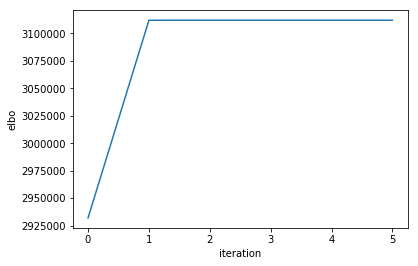

In [34]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
print('Z (unpermuted): \n', Z[0:10])

# Find the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]
perm_tmp = np.argmin(accuracy_mat, 1)

# check that we have a true permuation
if len(perm_tmp) == len(set(perm_tmp)):  
    perm = perm_tmp
else: 
    print('** procedure did not give a true permutation')
    perm = [0,1,2]

print('permutation: ', perm)
    
# print Z (permuted) and nu
print('Z (permuted) \n', Z[0:10, perm])
print('round_nu \n', round_nu[0:10,:])

print('l1 error (after permutation): ', \
    [ np.sum(np.abs(Z[:, perm[i]] - nu[:, i]))/Num_samples for i in range(K_inf) ])

print('\n')
print('true A (permuted): \n', A[perm, :])
print('phi_mu: \n', phi_mu.transpose())

print('\n')
print('true Pi (permuted): ', Pi)
print('computed Pi: ', Pi_computed)
plt.clf()
plt.plot(elbo)
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

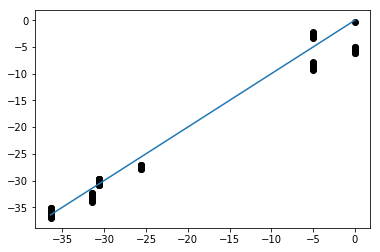

In [35]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 1
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')

diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
plt.plot(diag,diag)

plt.show()

# Run Stochastic VB 

In [8]:
VI_instance.re_init() # initialize

In [9]:
batch_size = 10
[tau, nu, phi_mu, phi_var, elbo] = \
    VI_instance.run_stochastic_VI(batch_size, decay_param = 0.9, max_iter=1000, tol=1e-6, verbose = True)

iteration:  0 elbo:  468948.07746
iteration:  1 elbo:  491247.343227
iteration:  2 elbo:  509322.068791
iteration:  3 elbo:  519534.571142
iteration:  4 elbo:  531247.302249
iteration:  5 elbo:  541105.551962
iteration:  6 elbo:  554310.939374
iteration:  7 elbo:  564539.964084
iteration:  8 elbo:  574064.942481
iteration:  9 elbo:  582575.59569
iteration:  10 elbo:  570210.256979
iteration:  11 elbo:  583046.363345
iteration:  12 elbo:  591488.798296
iteration:  13 elbo:  600142.866289
iteration:  14 elbo:  611083.306034
iteration:  15 elbo:  620463.877434
iteration:  16 elbo:  631576.600064
iteration:  17 elbo:  640399.667943
iteration:  18 elbo:  648464.829717
iteration:  19 elbo:  659643.030654
iteration:  20 elbo:  671937.319622
iteration:  21 elbo:  677126.769443
iteration:  22 elbo:  682065.670559
iteration:  23 elbo:  691891.086318
iteration:  24 elbo:  697505.710613
iteration:  25 elbo:  706791.011931
iteration:  26 elbo:  709892.045274
iteration:  27 elbo:  715799.589241
iter

In [6]:
print(phi_mu.T)
[tau, nu, phi_mu, phi_var, elbo] = VI_instance.run_cavi()
print(phi_mu.T)

[[  3.28538996e-17   3.71477511e-19]
 [  1.22215161e+01  -1.57718440e+01]
 [ -1.19479177e+01  -8.10713142e-02]]
iteration:  0 elbo:  948144.004562
iteration:  1 elbo:  948641.425774
iteration:  2 elbo:  948653.126579
iteration:  3 elbo:  948653.401817
iteration:  4 elbo:  948653.408291
iteration:  5 elbo:  948653.408443
iteration:  6 elbo:  948653.408447
iteration:  7 elbo:  948653.408447
elbo converged:  948653.408447
[[  0.           0.        ]
 [ 12.70926924 -15.81903821]
 [-15.18203516  -0.03859107]]


Z (unpermuted): 
 [[1 1 1]
 [1 1 1]
 [1 1 0]
 [0 1 0]
 [1 1 1]
 [0 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]]
** procedure did not give a true permutation
permutation:  [0, 1, 2]
Z (permuted) 
 [[1 1 1]
 [1 1 1]
 [1 1 0]
 [0 1 0]
 [1 1 1]
 [0 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]]
round_nu 
 [[ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]
l1 error (after permutation):  [0.85399999999999998, 0.14999999999999999, 0.72799999999999998]


true A (permuted): 
 [[ -4.56292503 -16.4070799 ]
 [ 14.39945263  -2.48764823]
 [  2.67705195   0.75207494]]
phi_mu: 
 [[  8.63811365e-18   3.30956090e-17]
 [  1.27337722e+01  -1.57967725e+01]
 [ -1.23542039e+01   2.23670888e-02]]


true Pi (permuted):  [ 0.8  0.8  0.8]
computed Pi:  [ 0.00660939  0.97535392  0.1570602 ]


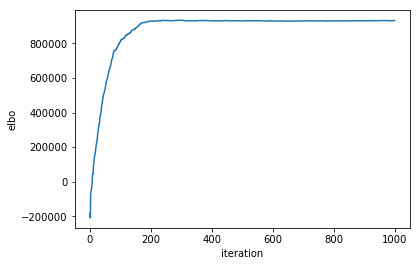

In [6]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
print('Z (unpermuted): \n', Z[0:10])

# Find the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]
perm_tmp = np.argmin(accuracy_mat, 1)

# check that we have a true permuation
if len(perm_tmp) == len(set(perm_tmp)):  
    perm = perm_tmp
else: 
    print('** procedure did not give a true permutation')
    perm = [0,1,2]

print('permutation: ', perm)
    
# print Z (permuted) and nu
print('Z (permuted) \n', Z[0:10, perm])
print('round_nu \n', round_nu[0:10,:])

print('l1 error (after permutation): ', \
    [ np.sum(np.abs(Z[:, perm[i]] - nu[:, i]))/Num_samples for i in range(K_inf) ])

print('\n')
print('true A (permuted): \n', A[perm, :])
print('phi_mu: \n', phi_mu.transpose())

print('\n')
print('true Pi (permuted): ', Pi)
print('computed Pi: ', Pi_computed)
plt.clf()
plt.plot(elbo)
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

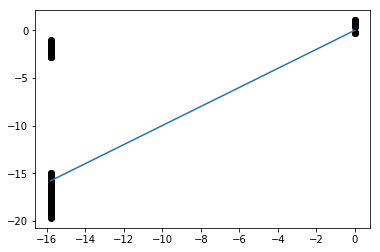

In [7]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 1
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')

diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
plt.plot(diag,diag)

plt.show()

# Gultekin: Annealing method

In [36]:
n_restart = 20
elbo_end = np.array([])

for i in range(n_restart): 
    VI_instance.re_init() # re initialize
    [tau_tmp, nu_tmp, phi_mu_tmp, phi_var_tmp, elbo] \
        = VI_instance.run_cavi_anneal(max_iter=200, tol=1e-6, verbose = False) # run cavi + annealing
        
    elbo_end = np.append(elbo_end, elbo[-1])
    
    # see if posterior predictive is better than all previous ones
    if (i == 0) or np.all(elbo_end[i] > elbo_end[:i]): 
        tau = deepcopy(tau_tmp)
        nu = deepcopy(nu_tmp)
        phi_mu = deepcopy(phi_mu_tmp)
        phi_var = deepcopy(phi_var_tmp)
    
    
print('max elbo: ', np.max(elbo_end))
print('average elbo', np.mean(elbo_end))


elbo converged:  3183959.48893
elbo converged:  3108155.44643
elbo converged:  3180327.70024
elbo converged:  3180327.70024
elbo converged:  3119879.04519
elbo converged:  3184642.66607
elbo converged:  3180976.26284
elbo converged:  3184642.66607
elbo converged:  3180550.18941
elbo converged:  3181076.57115
elbo converged:  3190923.60922
elbo converged:  3204562.41011
elbo converged:  3180550.18941
elbo converged:  3184239.73633
elbo converged:  3135385.02128
elbo converged:  3180002.06599
elbo converged:  3180550.18941
elbo converged:  3180002.06599
elbo converged:  3154409.86031
elbo converged:  3204562.41011
max elbo:  3204562.41011
average elbo 3173986.26474


Z (unpermuted): 
 [[1 1 1]
 [1 0 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [0 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 0]]
permutation:  [1 2 0]
Z (permuted) 
 [[1 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 0 1]
 [1 1 0]
 [1 1 1]
 [1 1 0]
 [1 0 1]]
round_nu 
 [[ 1.  1.  1.]
 [ 0.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]
 [ 1.  1.  1.]
 [ 1.  1.  0.]
 [ 1.  0.  1.]]
l1 error (after permutation):  [0.0, 8.7191837902723964e-70, 3.6075481068229804e-218]


true A (permuted): 
 [[-12.65695351 -27.44907626]
 [  2.92641795  -5.71810364]
 [-10.12861949  -2.83121684]]
phi_mu: 
 [[-12.65898125 -27.41449579]
 [  2.96454897  -5.71548179]
 [-10.17241765  -2.8167568 ]]


true Pi (permuted):  [ 0.8  0.8  0.8]
computed Pi:  [ 0.82551223  0.79775281  0.78982155]


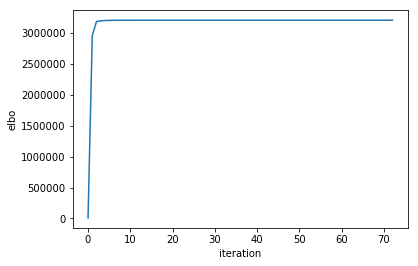

In [37]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
print('Z (unpermuted): \n', Z[0:10])

# Find the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]
perm_tmp = np.argmin(accuracy_mat, 1)

# check that we have a true permuation
if len(perm_tmp) == len(set(perm_tmp)):  
    perm = perm_tmp
else: 
    print('** procedure did not give a true permutation')
    perm = [0,1,2]

print('permutation: ', perm)
    
# print Z (permuted) and nu
print('Z (permuted) \n', Z[0:10, perm])
print('round_nu \n', round_nu[0:10,:])

print('l1 error (after permutation): ', \
    [ np.sum(np.abs(Z[:, perm[i]] - nu[:, i]))/Num_samples for i in range(K_inf) ])

print('\n')
print('true A (permuted): \n', A[perm, :])
print('phi_mu: \n', phi_mu.transpose())

print('\n')
print('true Pi (permuted): ', Pi)
print('computed Pi: ', Pi_computed)
plt.clf()
plt.plot(elbo)
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

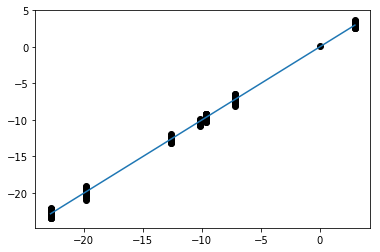

In [39]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 0
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')

diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
plt.plot(diag,diag)

plt.show()